In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from ezgatr.interfaces import point, rotation
from ezgatr.nets.mv_only_gatr import MVOnlyGATrModel, MVOnlyGATrMLP, MVOnlyGATrConfig
from ezgatr.nn.functional import equi_linear, geometric_product
from tqdm import tqdm
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.transforms import random_rotation, matrix_to_quaternion

In [2]:
def plot_pointcloud(points, title=""):
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, y, z)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [3]:
# Load the dolphin mesh.
device = "cuda:0"
trg_obj = "dolphin.obj"

# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

# We initialize the source shape to be a sphere of radius 1
src_mesh = ico_sphere(4, device)

/home/catcat/projects/img2pc/.venv/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [4]:
rot = random_rotation(dtype=torch.float, device=device)
g1 = nn.Parameter(
    rotation.encode_pga(matrix_to_quaternion(rot)).reshape(1, 1, 16),
    requires_grad=True,
)

# lin_params = nn.Parameter(torch.randn((1, 1, 9), device=device), requires_grad=True)
# gp1_params = nn.Parameter(torch.randn((1, 1, 16), device=device), requires_grad=True)
# gp2_params = nn.Parameter(torch.randn((1, 1, 16), device=device), requires_grad=True)
optimizer = torch.optim.Adam(
    # [lin_params, gp1_params, gp2_params],
    [g1],
    lr=3e-4,
    weight_decay=1e-5,
)

total_loss = 1.303837:   0%|          | 0/10001 [00:00<?, ?it/s]

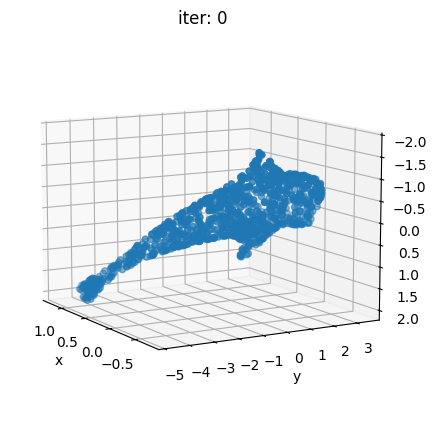

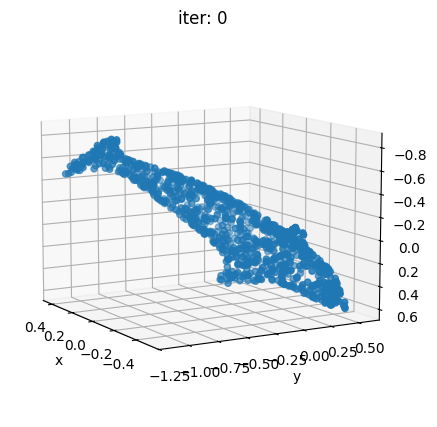

total_loss = 0.044758:  25%|██▍       | 2499/10001 [00:17<00:46, 159.81it/s]

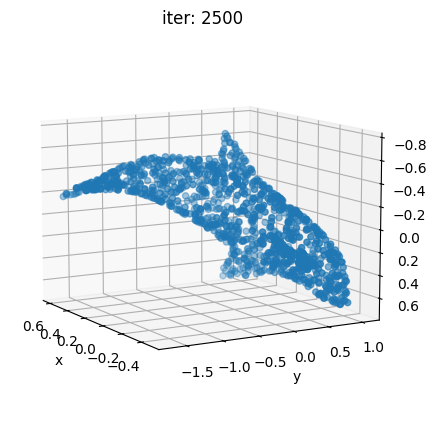

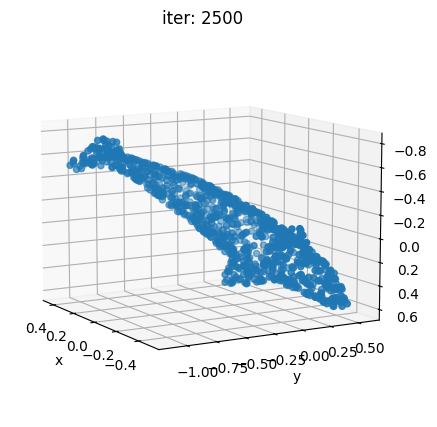

total_loss = 0.006199:  46%|████▌     | 4586/10001 [00:40<01:02, 86.63it/s] 

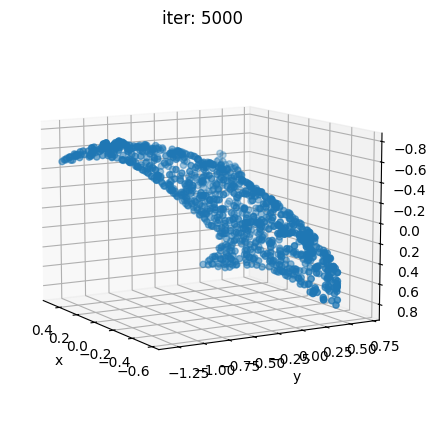

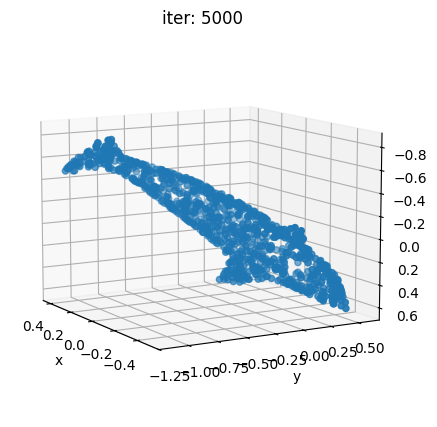

total_loss = 0.005050:  73%|███████▎  | 7299/10001 [01:03<00:25, 106.40it/s]

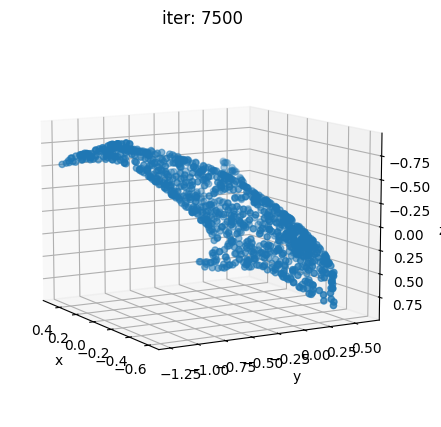

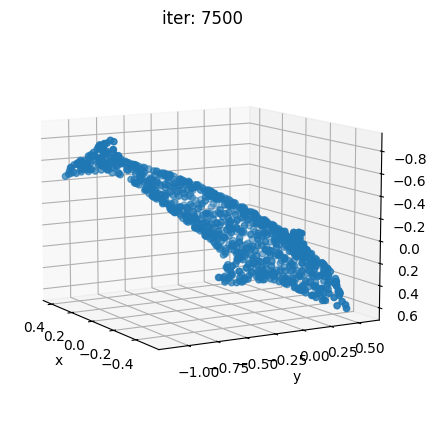

total_loss = 0.005342:  99%|█████████▉| 9900/10001 [01:27<00:00, 106.61it/s]

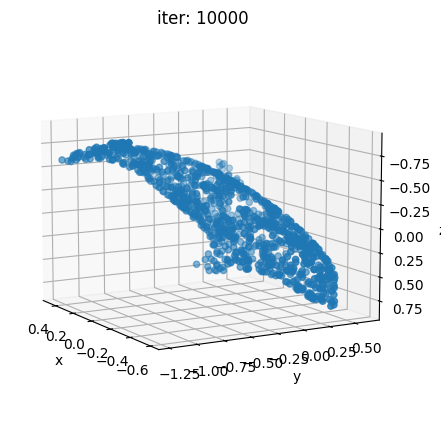

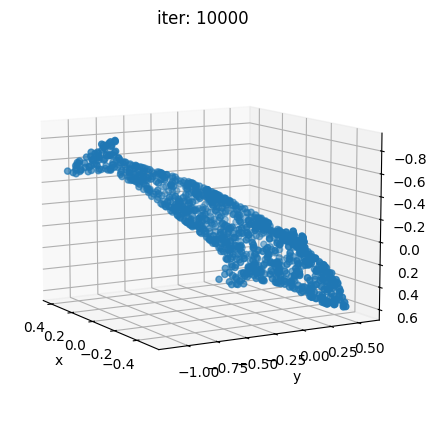

total_loss = 0.005342: 100%|██████████| 10001/10001 [01:28<00:00, 113.37it/s]


In [5]:
%matplotlib inline

criterion = nn.MSELoss()
losses = []

loop = tqdm(range(10001))
for i in loop:
    x = sample_points_from_meshes(trg_mesh, 1024)
    y = torch.einsum("bni, ji -> bnj", x.detach(), rot) # * 2 + torch.ones_like(x) * 0.1

    x = point.encode_pga(x).unsqueeze(-2)
    # p = geometric_product(geometric_product(g1, x), g2)
    # p = equi_linear(p, lin_params)
    p = geometric_product(g1, x)
    p = point.decode_pga(p).squeeze(-2)

    loss = criterion(p, y)
    losses.append(float(loss.detach().cpu()))

    loop.set_description('total_loss = %.6f' % loss)
    if i % 2500 == 0:
        plot_pointcloud(p, title="iter: %d" % i)
        plot_pointcloud(y, title="iter: %d" % i)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

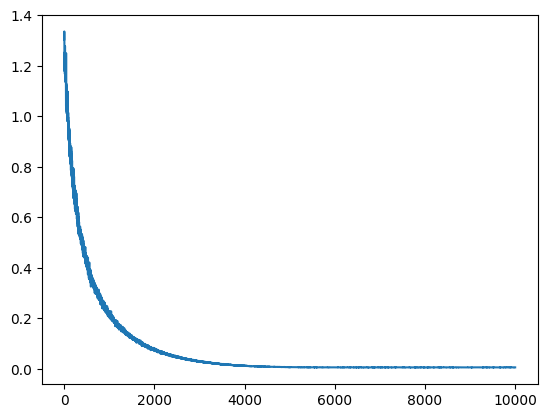

In [6]:
plt.plot(losses)